In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

<center><font size="+2">Importing and splitting the data into validation set</font></center>

In [2]:
#import data from csv into DF

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv', index_col='id')
test_for_sub = pd.read_csv('test.csv')

In [3]:
train.shape

(60000, 785)

In [4]:
#splitting out validation set and dividing by 255 to normalize dataset

x_train_full = train.drop(columns='label', axis=1)
y_train_full = train['label']

x_valid, x_train = x_train_full[:5000] / 255.0, x_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
x_test = test / 255

#reshaping
x_valid = x_valid.values.reshape(-1,28,28)
x_train = x_train.values.reshape(-1,28,28)
x_test = x_test.values.reshape(-1,28,28)

In [5]:
x_train_full.shape

(60000, 784)

In [6]:
x_valid.shape

(5000, 28, 28)

In [7]:
x_train.shape

(55000, 28, 28)

In [8]:
x_test.shape

(5000, 28, 28)

<center><font size="+2">Building the AutoEncoder</font></center>

In [9]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(30, activation='relu')
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28,28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

In [10]:
#setting optimzer and loss function and early callback

optimizer = keras.optimizers.Adam()
loss="sparse_categorical_crossentropy"
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [11]:
#compiling the model

stacked_ae.compile(loss=loss,
             optimizer=optimizer,
             metrics=["accuracy"])

In [12]:
#early stopping callback

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [13]:
#fitting the model and tracking how long it takes



start = datetime.datetime.now()

history = stacked_ae.fit(x_train, x_train, epochs=50, validation_data=[x_valid, x_valid], callbacks=[early_stopping_cb])

end = datetime.datetime.now()

print("Total Time: ", end-start)

Epoch 1/50


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [896,28] and labels shape [25088]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-13-972b10c287a2>:7) ]] [Op:__inference_train_function_996]

Function call stack:
train_function


In [22]:
stacked_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 30)                180130    
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28)            180884    
Total params: 361,014
Trainable params: 361,014
Non-trainable params: 0
_________________________________________________________________


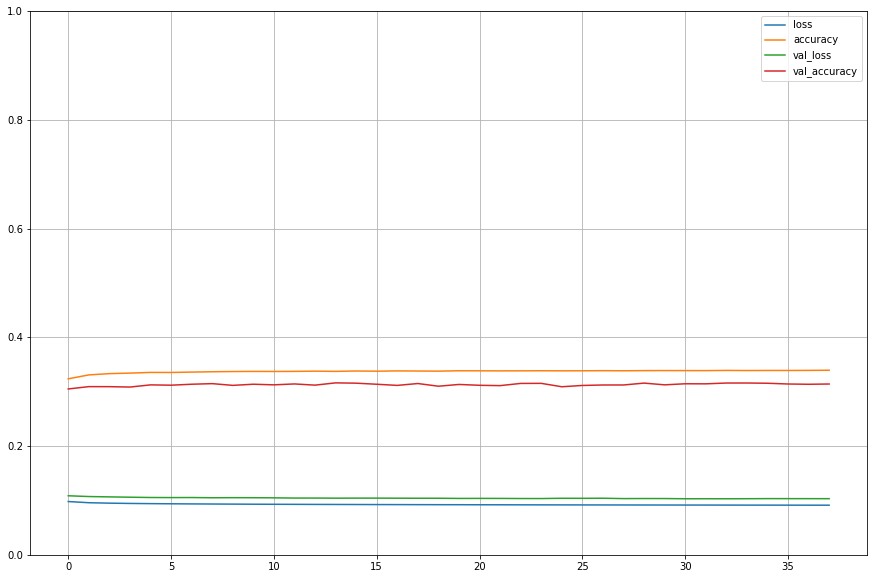

In [23]:
pd.DataFrame(history.history).plot(figsize=(15,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

<center><font size="+2">Visualizing the reconstructions</font></center>

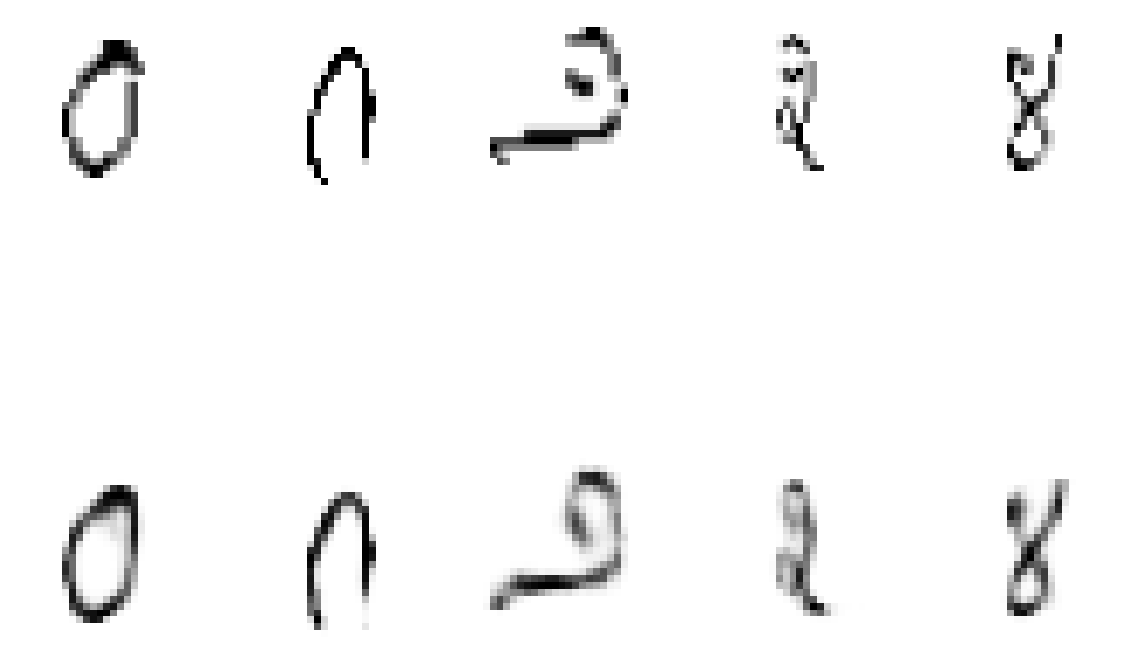

In [28]:
#function for reconstruction

def plot_image(image):
    plt.imshow(image.reshape(28,28), cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, n_images=5):
    reconstructions = model.predict(x_valid[:n_images])
    fig = plt.figure(figsize=(20, 15))
    for image_index in range (n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(x_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
show_reconstructions(stacked_ae)

<center><font size="+2">Creating DNN for predictions</font></center>

In [58]:
#checking weights for pre-trained AE layers

stacked_encoder.layers[0].get_weights()
stacked_encoder.layers[1].get_weights()
stacked_encoder.layers[2].get_weights()
stacked_encoder.layers[3].get_weights()

[array([[ 0.09470325, -0.02217995,  0.1137454 , ...,  0.13816175,
          0.02894231,  0.11776728],
        [-0.00090576,  0.02263019, -0.12495172, ..., -0.03002273,
         -0.08296748,  0.0342813 ],
        [-0.01064933,  0.0033202 , -0.27167663, ..., -0.290971  ,
          0.00204554, -0.03424184],
        ...,
        [ 0.12421428, -0.00204356, -0.22726513, ..., -0.01135427,
         -0.04731281,  0.03639203],
        [-0.07577936,  0.01467269,  0.09959889, ..., -0.08764288,
         -0.19718565,  0.01727319],
        [ 0.04854015,  0.01559175, -0.0037917 , ..., -0.02783388,
         -0.02824826, -0.04683819]], dtype=float32),
 array([ 0.24129216,  0.1723656 , -0.08678102, -0.1264824 ,  0.23723811,
        -0.10618175,  0.02715502,  0.24587171,  0.07399855, -0.37699828,
        -0.11060728,  0.04137243,  0.12183382, -0.00999295,  0.36620024,
        -0.05267849, -0.28569758, -0.12509835,  0.32919675,  0.04935936,
         0.5443192 , -0.07734293, -0.35976377,  0.1161037 ,  0.139

In [6]:
#creating DNN for predictions

model = keras.models.Sequential([
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


In [60]:
#copying weights from AE to new model

model.layers[0].set_weights(stacked_encoder.layers[0].get_weights())
model.layers[1].set_weights(stacked_encoder.layers[1].get_weights())
model.layers[2].set_weights(stacked_encoder.layers[2].get_weights())
model.layers[3].set_weights(stacked_encoder.layers[3].get_weights())

In [61]:
#verifying weights were copied

model.layers[0].get_weights()
model.layers[1].get_weights()
model.layers[2].get_weights()
model.layers[3].get_weights()

[array([[ 0.09470325, -0.02217995,  0.1137454 , ...,  0.13816175,
          0.02894231,  0.11776728],
        [-0.00090576,  0.02263019, -0.12495172, ..., -0.03002273,
         -0.08296748,  0.0342813 ],
        [-0.01064933,  0.0033202 , -0.27167663, ..., -0.290971  ,
          0.00204554, -0.03424184],
        ...,
        [ 0.12421428, -0.00204356, -0.22726513, ..., -0.01135427,
         -0.04731281,  0.03639203],
        [-0.07577936,  0.01467269,  0.09959889, ..., -0.08764288,
         -0.19718565,  0.01727319],
        [ 0.04854015,  0.01559175, -0.0037917 , ..., -0.02783388,
         -0.02824826, -0.04683819]], dtype=float32),
 array([ 0.24129216,  0.1723656 , -0.08678102, -0.1264824 ,  0.23723811,
        -0.10618175,  0.02715502,  0.24587171,  0.07399855, -0.37699828,
        -0.11060728,  0.04137243,  0.12183382, -0.00999295,  0.36620024,
        -0.05267849, -0.28569758, -0.12509835,  0.32919675,  0.04935936,
         0.5443192 , -0.07734293, -0.35976377,  0.1161037 ,  0.139

In [7]:
#setting optimzer and loss function and early callback

optimizer = keras.optimizers.Adam()
loss="sparse_categorical_crossentropy"
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [8]:
#compiling the model

model.compile(loss=loss,
             optimizer=optimizer,
             metrics=["accuracy"])

In [9]:
#fitting the model and tracking how long it takes

start = datetime.datetime.now()

history = model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid), callbacks=[early_stopping_cb])

end = datetime.datetime.now()

print("Total Time: ", end-start)

Epoch 1/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2688 - accuracy: 0.9195 - val_loss: 0.2901 - val_accuracy: 0.9322
Epoch 2/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0442 - accuracy: 0.9864 - val_loss: 0.1897 - val_accuracy: 0.9552
Epoch 3/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0271 - accuracy: 0.9913 - val_loss: 0.1986 - val_accuracy: 0.9558
Epoch 4/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0221 - accuracy: 0.9929 - val_loss: 0.1983 - val_accuracy: 0.9560
Epoch 5/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0153 - accuracy: 0.9952 - val_loss: 0.2151 - val_accuracy: 0.9578
Epoch 6/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0130 - accuracy: 0.9961 - val_loss: 0.3033 - val_accuracy: 0.9438
Epoch 7/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0102 - accuracy: 0.9967 - val_loss: 0.2622 - val_accuracy:

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 316,810
Trainable params: 316,810
Non-trainable params: 0
_________________________________________________________________


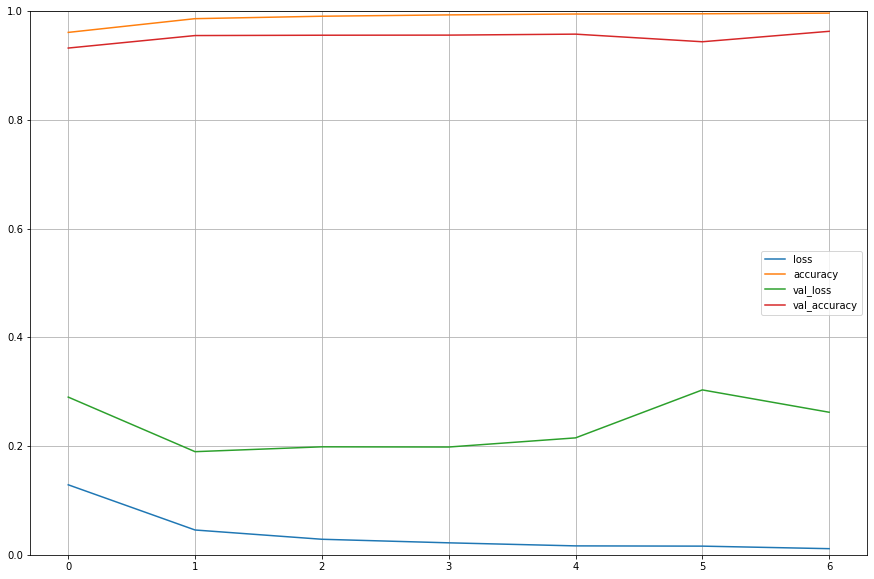

In [11]:
pd.DataFrame(history.history).plot(figsize=(15,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [12]:
predictions = np.argmax(model.predict(x_test), axis=-1)

In [13]:
df = pd.DataFrame({
        'id':test_for_sub['id'],
        'label': predictions
         })

df.to_csv('submission.csv', index=False)